AO3 analysis: interesting stuff
=================

This notebook presents the code used to generate the plots in [post 6]() of [my series on Archive of Our Own metadata]().  The underlying database is not, and will not be, public, but the code here can be reused by others with similar plotting needs.

This particular post discusses a bunch of random questions I thought I could answer with this data set.

In [2]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from adjustText import adjust_text

from ao3db import ao3db
from utils import (format_tag, write_dataframe, add_log_axis_labels, 
                   correlate, downsample, hits_v_kudos_plot, reorder_array, rolling_mean)

In [3]:
# Some settings that will help us make pretty plots
sns.set(style='whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
figsize = plt.gcf().get_size_inches()
cmap = plt.get_cmap("viridis")
single_color = sns.color_palette('dark')[2]

<Figure size 864x576 with 0 Axes>

In [4]:
db = ao3db()

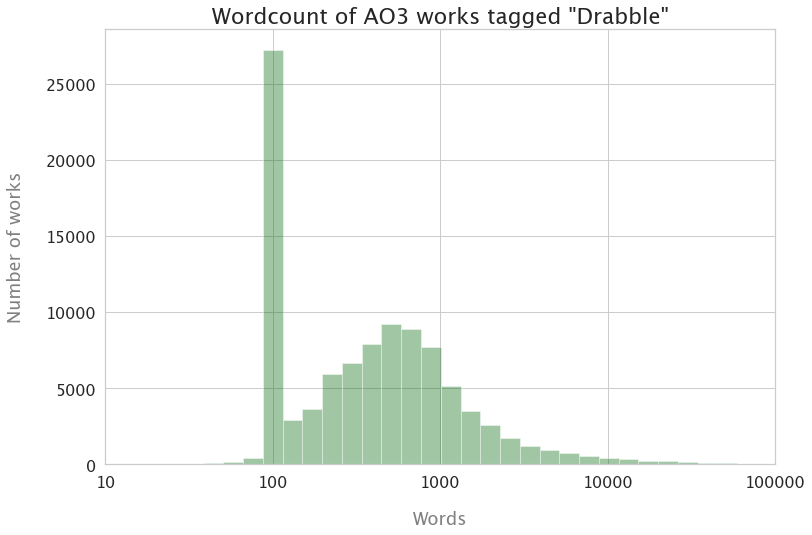

In [4]:
# DRABBLES
data = db.get_data("Words", "TagName", conditions="WHERE TagName=='Drabble'").drop(columns=['TagName']).replace('', 0)
fig, ax = plt.subplots()#gridspec_kw={"left": 0.3})
sns.distplot(np.log10(data['Words'].clip(lower=0.5)), kde=False, ax=ax, color=single_color)
ax.set_ylabel("Number of works")
add_log_axis_labels(ax)
ax.set_xlim((1, 5))
ax.set_title('Wordcount of AO3 works tagged "Drabble"')
fig.savefig("drabble_wordcount_histogram.png")

In [5]:
data = data.query("Words != 100")
print("Median and standard deviation of drabble words: {} pm {}".format(np.median(data['Words']), np.std(data['Words'])))

Median and standard deviation of drabble words: 520.0 pm 5807.677718008089


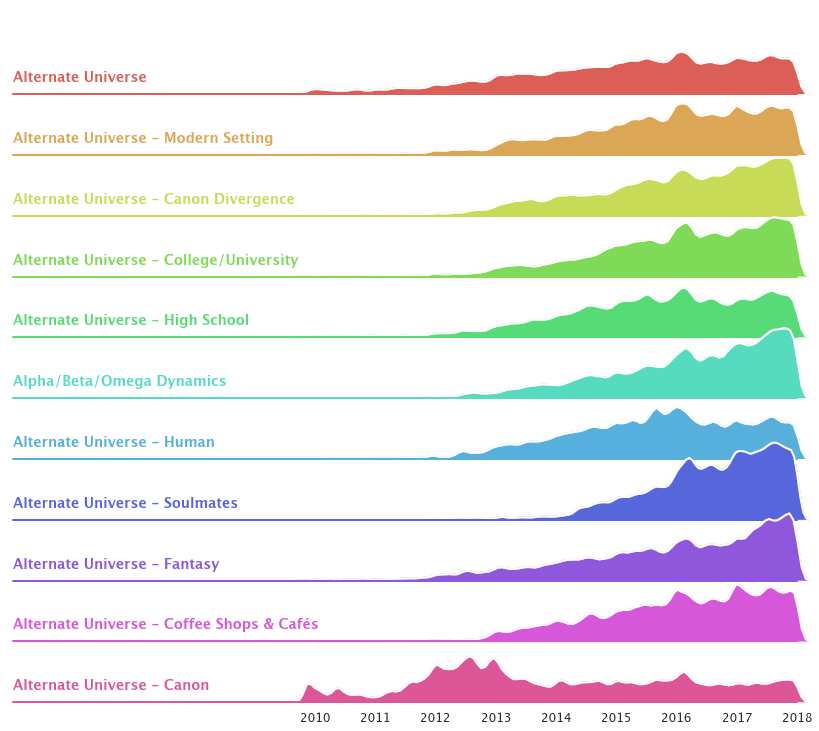

In [6]:
#AUs
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 18
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
# Since a work can be tagged with multiple tags that resolve to the same canonical tag,
# get rid of duplicate entries and then drop the "ID" col we don't need.

data = db.get_data("TagName", "Date", "ID", duplicates=False,
                   conditions=["LOWER(TagName) LIKE 'alternate%universe%'"])
data2 = db.get_data("TagName", "Date", "ID", duplicates=False,
                    conditions=["LOWER(TagName) LIKE 'alpha%beta%omega%'"])
data = pd.concat([data, data2])
data['TagName'] = data['TagName'].map(str.lower).map(format_tag)
data = data.drop_duplicates().drop(columns=["ID"])

data["OrdinalDate"] = [d.toordinal() for d in data['Date']] 

data = data.query('OrdinalDate >= {}'.format(datetime.date(2009, 11, 15).toordinal()))
data = data.query('OrdinalDate < {}'.format(datetime.date(2018, 1, 1).toordinal()))
data['TagName'] = data['TagName'].replace({'Alternate Universe - Coffee Shops *A* Cafés': 
                                           'Alternate Universe - Coffee Shops & Cafés'})
order = data["TagName"].value_counts().index[:11]
data = data[data['TagName'].isin(order)]

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# I couldn't get the figsize keyword to pass properly, so this is a hacky workaround
rcParams['figure.figsize'] = (18.0, 30.0)
g = sns.FacetGrid(data, row="TagName", hue="TagName", aspect=12, height=1, palette='hls', 
                  row_order=order, hue_order=order)

# Draw the densities in a few steps
g.map(sns.kdeplot, "OrdinalDate", clip_on=False, shade=True, alpha=1, lw=1.5, bw=25)
g.map(sns.kdeplot, "OrdinalDate", clip_on=False, color="w", lw=2, bw=25)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "OrdinalDate")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

desired_xrange = [datetime.date(yr, 1, 1).toordinal() for yr in range(2005, 2020)] # enough room for labels!
desired_xticks = [datetime.date(yr, 1, 1).toordinal() for yr in range(2010, 2019)]
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y') for x in desired_xticks]

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
#        g.set(xlim=(desired_xticks[0], dmax))
g.set(xticks=desired_xticks)
g.set(xticklabels=xlabels)
g.set(xlim=(desired_xrange[0], max(data['OrdinalDate'])))
g.set(xlabel='')
g.despine(bottom=True, left=True)        
g.savefig("alternate_universe_by_date.png")

In [7]:
sns.set(style="whitegrid")
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16


In [8]:
data = db.get_data("ID", "FandomName").dropna()
data["ID"] = data["ID"]%1000000000
data = data.drop_duplicates()
value_counts = data['ID'].value_counts()
value_counts = value_counts[value_counts>1]
data = data[data['ID'].isin(value_counts.index)]
cross_list = []
for oid in value_counts.index:
    mask = data['ID'] == oid
    this = data[mask]
    for i, fandom1 in enumerate(this['FandomName']):
        for fandom2 in this['FandomName'][i+1:]:
            if fandom1 < fandom2:
                cross_list.append("{} & {}".format(fandom1, fandom2))
            else:
                cross_list.append("{} & {}".format(fandom2, fandom1))

In [9]:
scl = cross_list

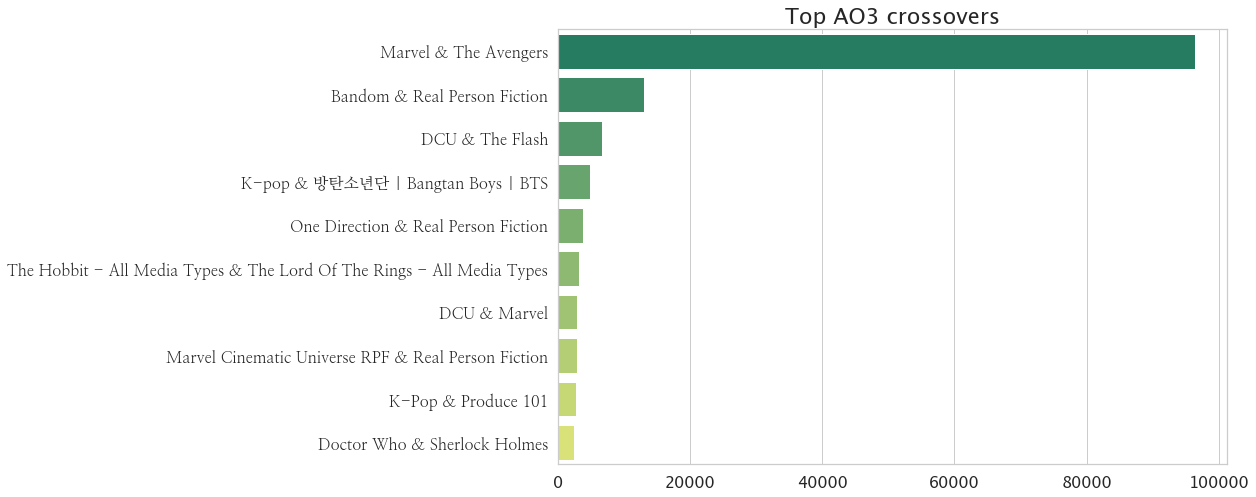

In [10]:
cross_list = pd.Series(scl)
kpop_label = [l for l in cross_list.unique() if 'K-Pop' in l and 'Bangtan Boys' in l][0]
cross_list = cross_list.replace({"Dcu & The Flash - All Media Types": "DCU & The Flash",
                                 kpop_label: "K-pop"+kpop_label[5:-3]+'BTS',
                                 'Dcu & Marvel': "DCU & Marvel",
                                 "Marvel Cinematic Universe Rpf & Real Person Fiction": 
                                     "Marvel Cinematic Universe RPF & Real Person Fiction",
                                 "K-Pop & Produce 101 (Tv)": "K-Pop & Produce 101",                    
                                 "Doctor Who &Amp; Related Fandoms & Sherlock Holmes &Amp; Related Fandoms": 
                                     "Doctor Who & Sherlock Holmes",
                                 "Marvel & The Avengers - Ambiguous Fandom": "Marvel & The Avengers",
                                 "One Direction (Band) & Real Person Fiction": "One Direction & Real Person Fiction"
                                 })
order = list(cross_list.value_counts().head(20).index)
order.remove("The Lord Of The Rings - All Media Types & Tolkien J. R. R. - Works &Amp; Related Fandoms")
order.remove("Clare Cassandra - Works & Shadowhunter Chronicles - All Media Types")
order.remove("It (2017) & King Stephen - Works")
order.remove("Conan Doyle Arthur - Works & Sherlock Holmes &Amp; Related Fandoms")
order.remove("The Hobbit - All Media Types & Tolkien J. R. R. - Works &Amp; Related Fandoms")
order.remove("Shadowhunter Chronicles - All Media Types & The Shadowhunter Chronicles - All Media Types")
order = order[:10]
fig, ax = plt.subplots()
sns.countplot(y=cross_list, order=order, ax=ax, palette='summer')

labels = ax.get_yticklabels()
for label in labels:
    label.set_fontname('NanumMyeongjo')
ax.set_yticklabels(labels)
ax.set_xlabel("")
ax.set_title("Top AO3 crossovers")
fig.savefig("crossover_barchart.png")

['DCU & Marvel', 'Doctor Who & Sherlock Holmes', 'Harry Potter & Marvel', 'Real Person Fiction & Supernatural', 'Guardians of Childhood & Hiccup Series', 'Doctor Who & Supernatural', 'Sherlock Holmes & Supernatural', 'Marvel & Real Person Fiction', 'Harry Potter & Sherlock Holmes', 'Harry Potter & Supernatural', 'Disney - All Media Types & Fairy Tales &Amp; Related Fandoms']


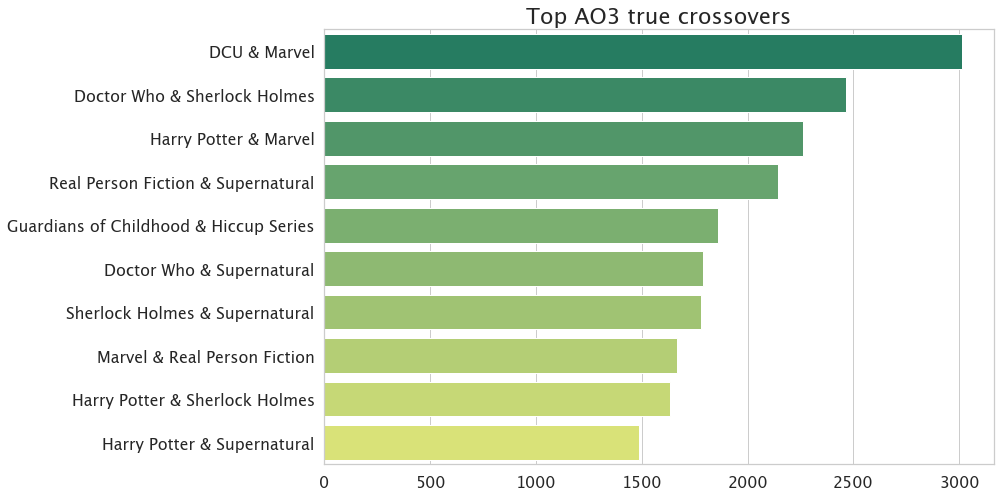

In [11]:
cross_list = pd.Series(scl)
kpop_label = [l for l in cross_list.unique() if 'K-Pop' in l and 'Bangtan Boys' in l][0]
cross_list = cross_list.replace({'Dcu & Marvel': "DCU & Marvel",
                                 "Doctor Who &Amp; Related Fandoms & Sherlock Holmes &Amp; Related Fandoms": 
                                     "Doctor Who & Sherlock Holmes",
                                 "Guardians Of Childhood &Amp; Related Fandoms & Hiccup Series - All Media Types":
                                     "Guardians of Childhood & Hiccup Series",
                                 "Doctor Who &Amp; Related Fandoms & Supernatural" : "Doctor Who & Supernatural",
                                 "Sherlock Holmes &Amp; Related Fandoms & Supernatural": 
                                     "Sherlock Holmes & Supernatural",
                                 "Harry Potter - J. K. Rowling & Sherlock Holmes &Amp; Related Fandoms":
                                     "Harry Potter & Sherlock Holmes",
                                 "Harry Potter - J. K. Rowling & Marvel": "Harry Potter & Marvel",
                                 'Harry Potter - J. K. Rowling & Supernatural': 'Harry Potter & Supernatural'
                                 })
order = list(cross_list.value_counts().head(30).index)
order.remove("The Lord Of The Rings - All Media Types & Tolkien J. R. R. - Works &Amp; Related Fandoms")
order.remove("Clare Cassandra - Works & Shadowhunter Chronicles - All Media Types")
order.remove("It (2017) & King Stephen - Works")
order.remove("Conan Doyle Arthur - Works & Sherlock Holmes &Amp; Related Fandoms")
order.remove("The Hobbit - All Media Types & Tolkien J. R. R. - Works &Amp; Related Fandoms")
order.remove("Shadowhunter Chronicles - All Media Types & The Shadowhunter Chronicles - All Media Types")
order.remove("Dcu & The Flash - All Media Types")
order.remove("Marvel Cinematic Universe Rpf & Real Person Fiction")
order.remove("K-Pop & Produce 101 (Tv)")
order.remove("Marvel & The Avengers - Ambiguous Fandom")
order.remove("Bandom & Real Person Fiction")
order.remove("One Direction (Band) & Real Person Fiction")
order.remove("The Hobbit - All Media Types & The Lord Of The Rings - All Media Types")
order.remove("Newsies (1992) & Newsies - All Media Types")
order.remove("Harry Potter - J. K. Rowling & The Avengers - Ambiguous Fandom")
order.remove("Dcu & Supergirl (Tv 2015)")
order.remove('The Maze Runner (Movies) & The Maze Runner Series - All Media Types')
order.remove('Clare Cassandra - Works & The Shadowhunter Chronicles - All Media Types')
order.remove(kpop_label)
print(order)

order = order[:10]
fig, ax = plt.subplots()
sns.countplot(y=cross_list, order=order, ax=ax, palette='summer')

ax.set_xlabel("")
ax.set_title("Top AO3 true crossovers")
plt.savefig('true_crossover_barchart.png')

In [12]:
data = db.get_data("ID", "TagName")


hp_ids = db.get_data("ID", "FandomName", 
                     conditions=["FandomName = 'Harry Potter - J. K. Rowling'"], 
                     duplicates=False)
nworks = len(hp_ids)
data = data[data["ID"].isin(hp_ids['ID'])]
#categories = db.get_data("TagName", "TagCategory")
#categories['TagName'] = categories['TagName'].map(format_tag)
#data = data[data["TagName"].isin(
#                    categories['TagName'][categories['TagCategory']=='free']
#           )]

tag_counts = data["TagName"].value_counts()

write_dataframe(tag_counts.head(1000), 'top_hp_tags.dat')


In [13]:
def lim_hits_v_kudos_plot(interpolators, labels, all_interpolator, cmap=plt.get_cmap("viridis"), 
                          figsize=(12, 8), xlim=None, ylim=None):
    """ Make a nice plot of all the hits vs kudos trendlines.  interpolators and labels should
        have the same ordering; interpolators should all be functions that return a single value
        for each element in the vector plot_x."""
    fig, ax = plt.subplots(figsize=(2*figsize[0], figsize[1]), gridspec_kw={"right": 0.7})
    max_x = []
    max_y = []
    colors = []
    for i, (x,y) in enumerate(interpolators):
        if not np.any(y>0):
            max_x.append(None)
            max_y.append(None)
            colors.append(None)
            continue
        max_x.append(np.max(x[y>0]))
        max_y.append(np.max(y[y>0]))
        color = cmap(1.0*i/len(interpolators))
        colors.append(color)
        ax.plot(x, rolling_mean(y), color=color)
    x, y = all_interpolator
    max_x.append(np.max(x[y>0]))
    max_y.append(np.max(y[y>0]))
    ax.plot(x, rolling_mean(y), color=cmap(1.0))
    annotations = []
    for x, y, label, color in zip(max_x, max_y, labels+["All works"], colors+[cmap(1.0)]):
        if x is not None:
            annotations.append(ax.text(x, y, label, color=color))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    adjust_text(annotations)
    ax.set_xlabel("Hits")
    ax.set_ylabel("Kudos")
    return fig


/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/adjustText/__init__.py:31: RuntimeWarning: invalid value encountered in less
  x_in = np.logical_and(x>x1, x<x2)
/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/adjustText/__init__.py:31: RuntimeWarning: invalid value encountered in greater
  x_in = np.logical_and(x>x1, x<x2)
/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)


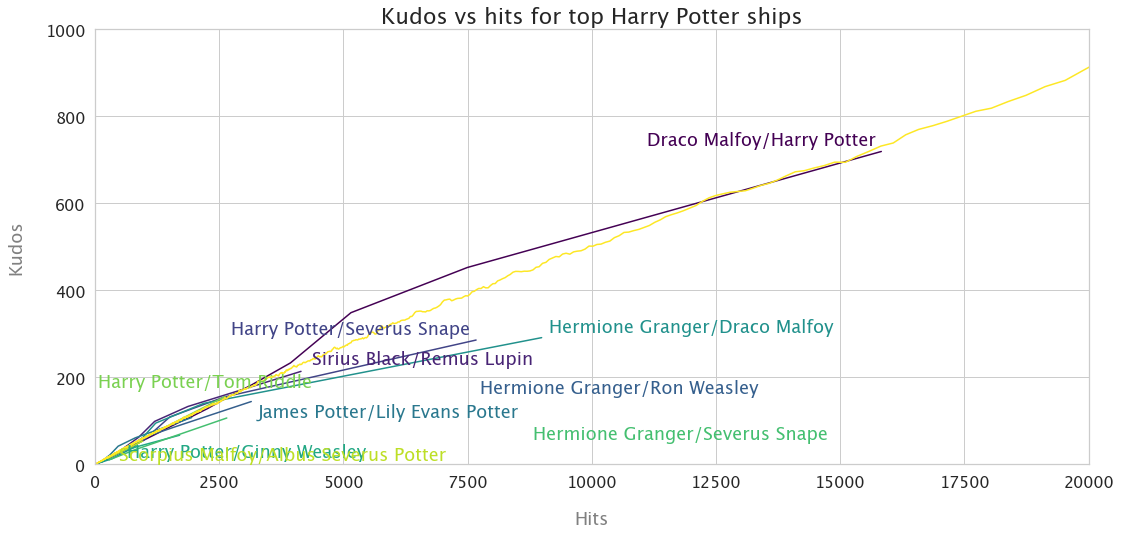

In [14]:
chosen_ships = ["Draco%20Malfoy*s*Harry%20Potter",
                "Sirius%20Black*s*Remus%20Lupin",
                "Harry%20Potter*s*Severus%20Snape",
                "Hermione%20Granger*s*Ron%20Weasley",
                "James%20Potter*s*Lily%20Evans%20Potter",
                "Hermione%20Granger*s*Draco%20Malfoy",
                "Harry%20Potter*s*Ginny%20Weasley",
                "Hermione%20Granger*s*Severus%20Snape",
                "Harry%20Potter*s*Tom%20Riddle",
                "Scorpius%20Malfoy*s*Albus%20Severus%20Potter"]

all_data = db.get_data("Hits", "Kudos")
all_data = all_data.loc[~(all_data['Kudos'].str.contains('<').fillna(False))]
kudos_vs_hits = downsample(all_data)

data = db.get_data('ID', 'Hits', 'Kudos', 'TagName', 
                   conditions=["Hits IS NOT NULL", 
                               'TagName IN ("{}")'.format('", "'.join(chosen_ships))])
data['TagName'] = data["TagName"].map(format_tag)

chosen_ships = [format_tag(c) for c in chosen_ships]
interpolators = []
labels = []
for ship in chosen_ships:
    this = data.query(u'TagName == "{}"'.format(ship))
    if len(this):
        labels.append(format_tag(ship))
        interpolators.append(downsample(this))
fig = lim_hits_v_kudos_plot(interpolators, labels, kudos_vs_hits, xlim=(0, 20000), ylim=(0, 1000))
fig.gca().set_title('Kudos vs hits for top Harry Potter ships')
fig.savefig("kudos_v_hits_per_harrypotter_ship.png")

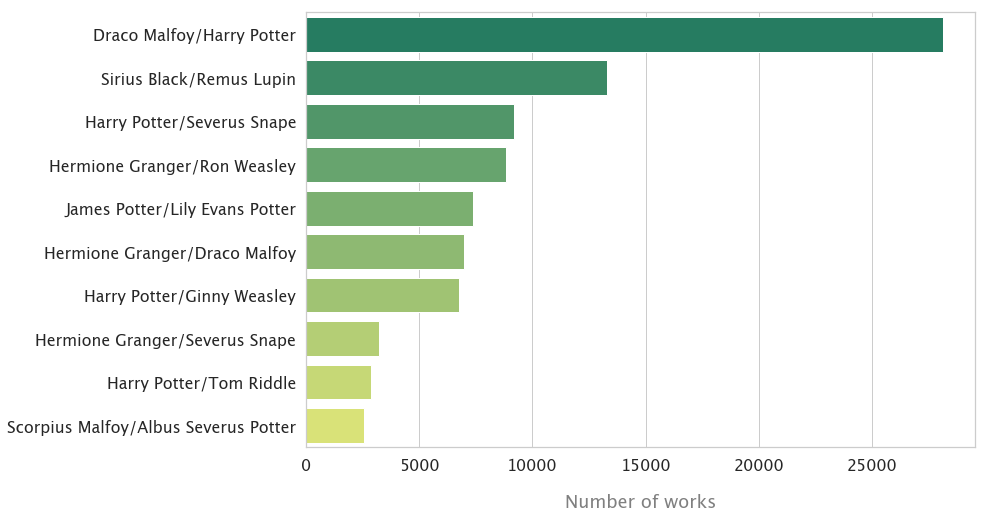

In [15]:
sns.countplot(y=data['TagName'], order=chosen_ships, palette='summer')
plt.xlabel("Number of works")
plt.ylabel("")
ax.set_title("Top Harry Potter ships")
plt.savefig("hp_ships_barchart.png")

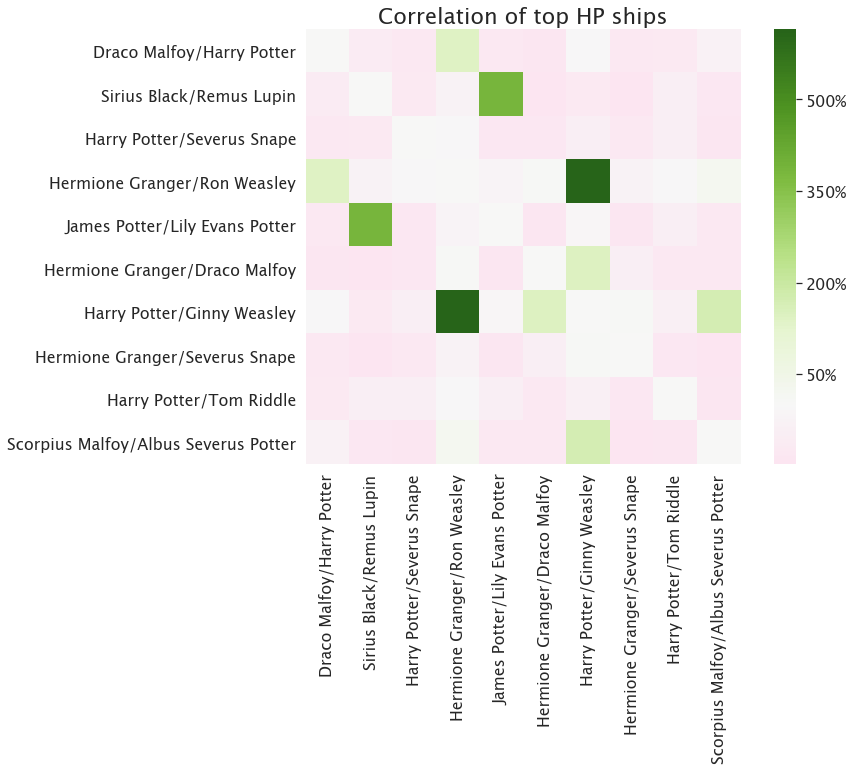

In [16]:
fig, ax = plt.subplots()
indices, heatmap_matrix, norm_heatmap_matrix = correlate(data, "TagName", nworks=nworks)
norm_heatmap_matrix = reorder_array(norm_heatmap_matrix, indices, chosen_ships)
sns.heatmap(norm_heatmap_matrix, xticklabels=chosen_ships, yticklabels=chosen_ships, ax=ax, center=1, cmap="PiYG")
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation of top HP ships")
fig.savefig("hp_ship_heatmap.png")

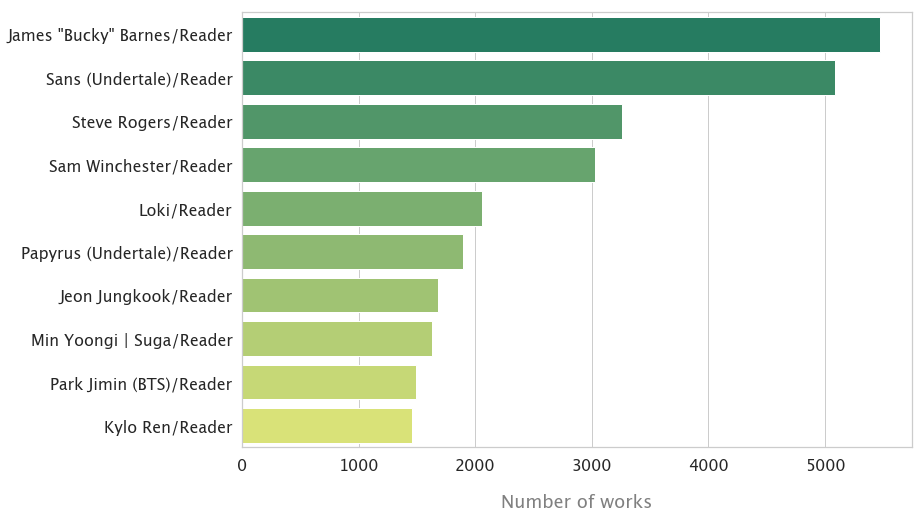

In [21]:
#Reader pairings
data = db.get_data("TagName", conditions="WHERE LOWER(TagName) LIKE '%reader%'")
data['TagName'] = data["TagName"].map(format_tag)
data = data[data["TagName"].str.contains('/')]
top_pairings = data['TagName'].value_counts().index[:10]
data = data.loc[data["TagName"].isin(top_pairings)]

fig, ax = plt.subplots()
sns.countplot(y=data['TagName'], ax=ax, order=top_pairings, palette='summer')
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=60, horizontalalignment='right')
ax.set_ylabel("")
ax.set_xlabel("Number of works")
labels = ax.get_yticklabels()
labels[-2] = "Park Jimin (BTS)/Reader"
ax.set_yticklabels(labels)

fig.savefig("reader_pairings.png")

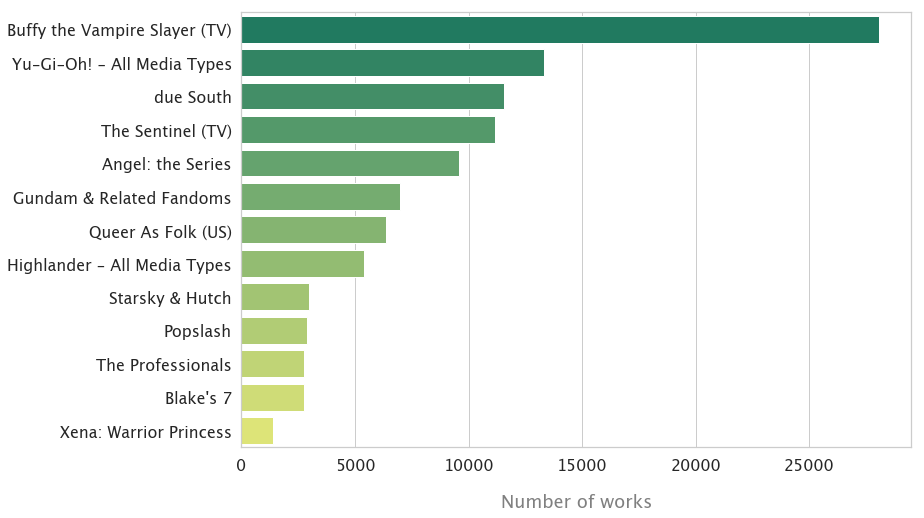

In [5]:
former_fandoms = [("Buffy the Vampire Slayer (TV)", 28076), 
                  ("Angel: the Series", 9586),
                  ("due South", 11559), 
                  ("The Sentinel (TV)", 11184), 
                  ("Yu-Gi-Oh! - All Media Types", 13300),
                  ("Queer As Folk (US)", 6370),
                  ("Highlander - All Media Types", 5378),
                  ("Blake's 7", 2741),
                  ("The Professionals", 2756),
#                  ("Hard Core Logo (1996)", 373),
#                  ("Master And Commander - All Media Types", 632),
                  ("Gundam & Related Fandoms", 6988),
                  ("Popslash", 2886),
                  ("Starsky & Hutch", 2965),
                  #("Hercules: The Legendary Journeys", 533),
                  ("Xena: Warrior Princess", 1400)
                 ] # Counts as of Mar 23, 2019
former_fandoms = pd.DataFrame(former_fandoms, columns=["FandomName", "WorksCount"]).sort_values("WorksCount", ascending=False)
fig, ax = plt.subplots()
sns.barplot(y='FandomName', x='WorksCount', data=former_fandoms, ax=ax, palette='summer') 
ax.set_ylabel("")
ax.set_xlabel("Number of works")
fig.savefig("old_fandoms.png")